# CUSTOMER SEGMENTATION

In [1]:
# Import standard library
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import datetime as dt
from datetime import timedelta

import plotly.graph_objs as go
import plotly.offline as pyoff

# K-Mean Model
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Hierarchical Model
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

## 1. Data Exploration

In [2]:
# Loading 'Online Retail' data transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based
df = pd.read_csv('OnlineRetail.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
# Check information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Figure1: Dataset informatoin

## 2. Data preparation

In [6]:
# check duplicate and it's %
print('Total Duplicate as number\t: {}'.format(df.duplicated().sum()))
print('Total Duplicate as percent\t: {}%'.format(round((df.duplicated().sum()/df.shape[0])*100), 2)) # df.shape[0]: total of rows

df.drop_duplicates(inplace = True)
print('Total Duplicate after removed\t: {}'.format(df.duplicated().sum()))

Total Duplicate as number	: 5268
Total Duplicate as percent	: 1%
Total Duplicate after removed	: 0


In [7]:
# Find null for all columns
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64


As we can see, there are missing value in column Description & CustomerID. But we noted that the root cause of missing value in column Description is came from the missing value of column CustomerID. So removing missing value from CustomerID are also remove missing value from Description. 

Since we can not fill the null value with other value or using statistic method to fill the value, we need to drop the null value in CustomerID column.

In [8]:
# CustomerID, find null value and it's %
print('CustomerID: Total null as number\t: {}'.format(df['CustomerID'].isnull().sum()))
print('CustomerID: Total null as percen\t: {}%'.format(round((df['CustomerID'].isnull().sum()/df.shape[0])*100), 2))

df = df[df['CustomerID'].notna()]
print('CustomerID: Total null after cleaning\t: {}'.format(df['CustomerID'].isnull().sum()))

CustomerID: Total null as number	: 135037
CustomerID: Total null as percen	: 25%
CustomerID: Total null after cleaning	: 0


In [9]:
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


Cancellation ordered

If InvoiceNo starts with letter 'c', it indicates a cancellation Please note that every transaction that was cancelled make negative value in Quantity & Unitprice column
So removing cancellation transaction are also removed negative vaule from Quantity & Unitprice

In [10]:
cancelOrder = df['InvoiceNo']
print('cancellation order as number: {}'.format(cancelOrder.str.contains('C', regex = True).sum()))
print('cancellation order as percent: {}%'.format(round(((cancelOrder.str.contains('C', regex = True).sum()/df.shape[0])*100), 2)))

cancellation order as number: 8872
cancellation order as percent: 2.21%


In [11]:
# Remove cancellation order
astr = cancelOrder.str.contains('C', regex = True)
astr.fillna(0, inplace = True)
astr = astr.astype(int)
print(astr.value_counts())

df['cancelOrder'] = astr
df = df[df['cancelOrder'] == 0] 
print('Number of cancellation order: {}'.format((df['cancelOrder'] == 1).sum()))
df = df.drop(['cancelOrder'], axis = 1)

0    392732
1      8872
Name: InvoiceNo, dtype: int64
Number of cancellation order: 0


In [12]:
# Quantity & UnitPrice, find negative value and it's %
print('Quantity: Count negaitve value as number\t: {}'.format((df['Quantity'] < 0).sum()))
print('UnitPrice: Count negaitve value as number\t: {}'.format((df['UnitPrice'] < 0).sum()))

Quantity: Count negaitve value as number	: 0
UnitPrice: Count negaitve value as number	: 0


In [13]:
# Function to remove outlier 
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

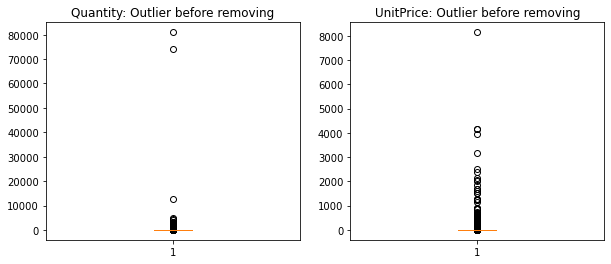

In [14]:
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1,2), (0,0)) 
ax2 = plt.subplot2grid((1,2), (0,1)) 

# Outlier visualization for Quantity column
ax1.boxplot(df['Quantity'])
ax1.set_title("Quantity: Outlier before removing")

# Outlier visulization for UnitPrice column
ax2.boxplot(df['UnitPrice'])
x = ax2.set_title("UnitPrice: Outlier before removing")

In [15]:
temStr = df.shape[0]
print('Record before remove Outlier:', temStr)

Record before remove Outlier: 392732


In [16]:
# remove outlie for Quantiy
df = remove_outlier(df, 'Quantity')

# remove outlie for UnitPrice
df = remove_outlier(df, 'UnitPrice')

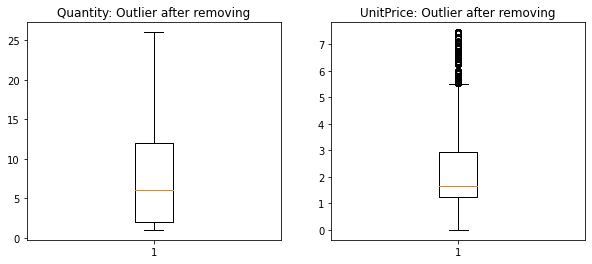

In [17]:
fig = plt.figure(figsize = (10, 4))
ax1 = plt.subplot2grid((1,2), (0,0)) 
ax2 = plt.subplot2grid((1,2), (0,1)) 

# Outlier visualization for Quantity column
ax1.boxplot(df['Quantity'])
ax1.set_title("Quantity: Outlier after removing")

# Outlier visulization for UnitPrice column
ax2.boxplot(df['UnitPrice'])
x = ax2.set_title("UnitPrice: Outlier after removing")

After removing outlier, it’s look like there are another outlier still existed. Indeed, it is not. We considering that it is group of price of luxury products

In [18]:
print('Total removed as number\t\t\t:', temStr - df.shape[0])
print('Total removed as percent\t\t: {}%'.format( round(((temStr - df.shape[0])/temStr)*100), 2))
print('Record records after remove outlier\t:', df.shape[0])

Total removed as number			: 60087
Total removed as percent		: 15%
Record records after remove outlier	: 332645


In [19]:
# Customer distribution by Country
df_CustByCountry = df[['Country', 'CustomerID']]
df_CustByCountry = df_CustByCountry.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending = False)
df_CustByCountry['%CustomerID'] = round((df_CustByCountry['CustomerID']/df_CustByCountry['CustomerID'].sum(axis = 0))*100, 2)
df_CustByCountry.reset_index(drop = True,inplace = True)
df_CustByCountry.head()

,Country,CustomerID,%CustomerID
0,United Kingdom,299750,90.11
1,Germany,7439,2.24
2,France,6882,2.07
3,EIRE,5423,1.63
4,Spain,2039,0.61


In [20]:
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


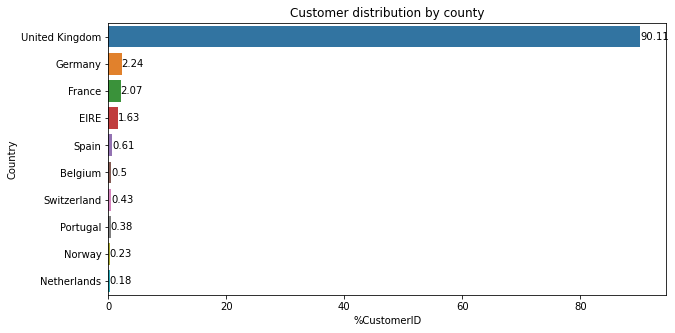

In [21]:
# Customer distribution by county visualization
plt.figure(figsize=(10,5))
plt.title('Customer distribution by county')
ax = sns.barplot(x = '%CustomerID', y = 'Country', data = df_CustByCountry[:10])
for i in ax.containers:
    ax.bar_label(i,)

Based on the graph, 90% of customer are come from United Kingdom

In [22]:
# keep only United Kingdom data
df_uk = df[df.Country == 'United Kingdom']

# Calculate total payment
df_uk['TotalPayment'] = df_uk['Quantity'] * df_uk['UnitPrice']

# Convert string date to date time (yyyy-mm-dd---)
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])

df_uk.shape

(299750, 9)

## 3. RFM Approach (Recency Frequency, Monetary)
- Recency = Recently InvoiceDate  - Last InvoiceDate
- Frequency = Number of transaction (count InvoiceNo)
- Monetary = Sum of TotalPayment for each customer 

In [23]:
# Find end date
# we need to add one day to make range for last recored. So if record made in the last day of record, recency would be 1 
eDate = df_uk['InvoiceDate'].max()
eDate = eDate + timedelta(days = 1)
print('End date is:', eDate)

End date is: 2011-12-11 17:19:00


In [24]:
# Create table RFM score
RFM = df_uk.groupby('CustomerID').agg({'InvoiceDate': lambda x: (eDate - x.max()).days, 
                                       'InvoiceNo': lambda x: len(x), 
                                       'TotalPayment': lambda x: x.sum()})

# Convert integer: number day of purchase have to convert to integer
RFM['InvoiceDate'] = RFM['InvoiceDate'].astype(int)

# Rename column 
RFM.rename(columns = {'InvoiceDate' : 'Recency', 'InvoiceNo' : 'Frequency', 'TotalPayment' : 'Monetary'}, inplace = True)
RFM.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12747.0,24,78,2640.41
1,12748.0,5,4041,20345.55
2,12749.0,24,143,2662.73
3,12820.0,46,58,923.62
4,12821.0,97,5,75.72


Now we split the metrics into segments using quantiles. We will assign a score from 1 to 4 to each Recency, Frequency and Monetary respectively. 1 is the highest value, and 4 is the lowest value. A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.

In [25]:
# Quantile
QFM = RFM.quantile(q = [0.25, 0.5, 0.75])
QFM = QFM.to_dict()
QFM

{'Recency': {0.25: 23.0, 0.5: 62.0, 0.75: 163.0},
 'Frequency': {0.25: 14.0, 0.5: 35.0, 0.75: 87.0},
 'Monetary': {0.25: 199.82500000000002, 0.5: 446.71, 0.75: 1091.335}}

In [26]:
# Function to create RFM segment

# The lower value it is, the better customer they are. It mean customer more engaged
def RScore(x, p, d):
    if x<= d[p][0.25]:
        return 1
    if x<= d[p][0.5]: 
        return 2
    if x<= d[p][0.75]: 
        return 3
    else: 
        return 4

# The higher value it is, the better customer they are. It mean they are mostly purchased or hight payment.    
def FMScore(x, p, d):
    if x<= d[p][0.25]: 
        return 4
    if x<= d[p][0.5]: 
        return 3
    if x<= d[p][0.75]: 
        return 2
    else: 
        return 1

In [27]:
# Calulate and add R, F, M segment into existing dataset
RFM['R'] = RFM['Recency'].apply(RScore, args = ('Recency', QFM,))
RFM['F'] = RFM['Frequency'].apply(FMScore, args = ('Frequency', QFM,))
RFM['M'] = RFM['Monetary'].apply(FMScore, args = ('Monetary', QFM,))

# Combine RFM as group and add into existing dataset
RFM['RFMGroup'] = RFM.R.map(str) + RFM.F.map(str) + RFM.M.map(str)

# Calculate total of RFM Scrore and add into existing dataset: The lower score it is, the better customer they are.
RFM['RFMScore'] = RFM[['R', 'F', 'M']].sum(axis = 1)
RFM.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
0,12747.0,24,78,2640.41,2,2,1,221,5
1,12748.0,5,4041,20345.55,1,1,1,111,3
2,12749.0,24,143,2662.73,2,1,1,211,4
3,12820.0,46,58,923.62,2,2,2,222,6
4,12821.0,97,5,75.72,3,4,4,344,11


In [28]:
# Assign Level to customer
cluster_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFM.RFMScore, q = 4, labels = cluster_Level)
RFM['Level'] = Score_cuts.values
RFM.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,Level
0,12747.0,24,78,2640.41,2,2,1,221,5,Platinum
1,12748.0,5,4041,20345.55,1,1,1,111,3,Platinum
2,12749.0,24,143,2662.73,2,1,1,211,4,Platinum
3,12820.0,46,58,923.62,2,2,2,222,6,Gold
4,12821.0,97,5,75.72,3,4,4,344,11,Bronze


In [29]:
# Find number of customer & their payment in each cluster
RFM_Cluster = RFM[['Monetary', 'Level']]
RFM_Cluster.head()

,Monetary,Level
CustomerID,,
12747.0,2640.41,Platinum
12748.0,20345.55,Platinum
12749.0,2662.73,Platinum
12820.0,923.62,Gold
12821.0,75.72,Bronze


In [30]:
#Function on CSS created for this
from IPython.display import display_html
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html() + "\xa0" * 10 # space = "\xa0" * 10
    display_html(html_str.replace('table','table style = "display:inline"'), raw = True)

In [31]:
# Split customer base on thier cluster

# Platinum group
df_Platinum = RFM_Cluster[RFM_Cluster['Level'] == 'Platinum']

# Gold group
df_Gold = RFM_Cluster[RFM_Cluster['Level'] == 'Gold']

# Silver group
df_Silver = RFM_Cluster[RFM_Cluster['Level'] == 'Silver']

# Bronze group
df_Bronze = RFM_Cluster[RFM_Cluster['Level'] == 'Bronze']

In [32]:
display_side_by_side(df_Platinum.head(), df_Gold.head(), df_Silver.head(), df_Bronze.head())

,Monetary,Level
CustomerID,,
12747.0,2640.41,Platinum
12748.0,20345.55,Platinum
12749.0,2662.73,Platinum
12826.0,1438.30,Platinum
12836.0,1620.12,Platinum
,Monetary,Level
CustomerID,,
12820.0,923.62,Gold
12822.0,743.28,Gold


In [33]:
display_side_by_side(df_Platinum.describe(), df_Gold.describe(), df_Silver.describe(), df_Bronze.describe())

,Monetary
count,1128.000000
mean,2368.277270
std,2706.560805
min,202.970000
25%,1109.250000
50%,1710.280000
75%,2683.940000
max,36019.840000
,Monetary
count,1121.000000


In [34]:
# calculate payment & count number of customer for each cluster
RFM_compare = pd.DataFrame({'NumCust' : [df_Platinum['Monetary'].count(),
                                          df_Gold['Monetary'].count(), 
                                          df_Silver['Monetary'].count(),
                                          df_Bronze['Monetary'].count()],
                            'Payment' : [round(df_Platinum['Monetary'].sum()), 
                                        round(df_Gold['Monetary'].sum()), 
                                        round(df_Silver['Monetary'].sum()), 
                                        round(df_Bronze['Monetary'].sum())]
                    })

RFM_compare = RFM_compare.set_axis(['Platinum', 'Gold', 'Silver', 'Bronze'])
#RFM_compare = pd.DataFrame(RFM_compare.to_dict('index'))
RFM_compare

,NumCust,Payment
Platinum,1128,2671417
Gold,1121,694132
Silver,840,217290
Bronze,694,86612


In [35]:
rfm_num_dic = RFM_compare['NumCust'].to_dict()
rfm_pym_dic = RFM_compare['Payment'].to_dict()

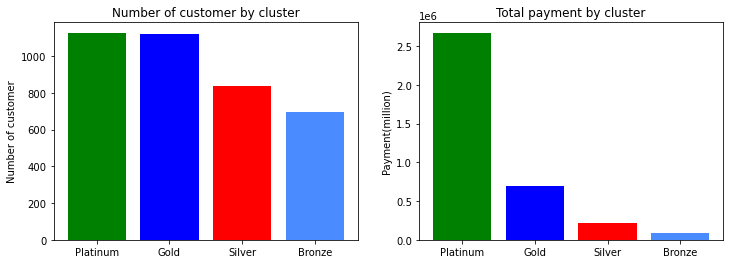

In [36]:
fig = plt.figure(figsize = (12, 4))
ax1 = plt.subplot2grid((1,2), (0,0)) 
ax2 = plt.subplot2grid((1,2), (0,1)) 

# Number of customer in each cluster
ax1.bar(rfm_num_dic.keys(), rfm_num_dic.values(), color = ['green', 'blue', 'red', '#4a8cff'])
ax1.set_title("Number of customer by cluster")
ax1.set_ylabel('Number of customer')

# Total payment of each cluster
ax2.bar(rfm_pym_dic.keys(), rfm_pym_dic.values(), color = ['green', 'blue', 'red', '#4a8cff'])
ax2.set_title("Total payment by cluster")
x = ax2.set_ylabel('Payment(million)')

<function matplotlib.pyplot.show(close=None, block=None)>

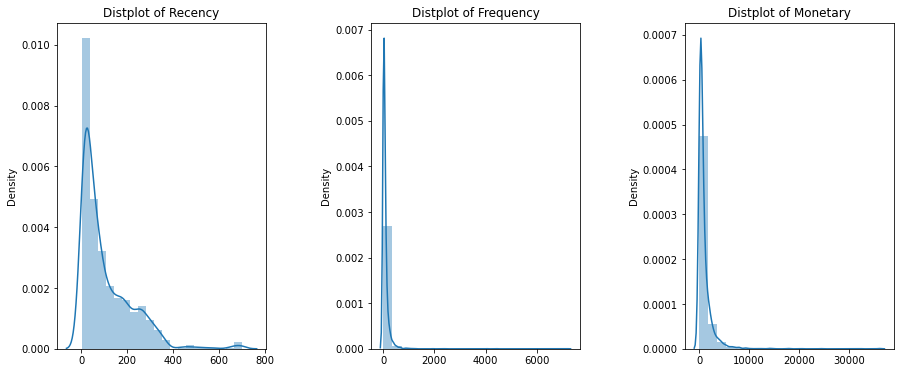

In [37]:
# distribution of Recency, Frequency, and Monetary
plt.figure(1, figsize = (15, 6))
n = 0
for x in ['Recency', 'Frequency', 'Monetary']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.distplot([RFM[x]], bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show

Based on graph above, the data is highly skewed, therefore we will perform log transformations to reduce the skewness of each variable. We added a small constant as log transformation demands all the values to be positive.

In [38]:
# Removing Skewness: since our dateset has no negative value, so we will use log transformation to normalize data
# Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFM[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
Log_Tfd_Data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747.0,3.178,4.357,7.879
12748.0,1.609,8.304,9.921
12749.0,3.178,4.963,7.887
12820.0,3.829,4.060,6.828
12821.0,4.575,1.609,4.327


<function matplotlib.pyplot.show(close=None, block=None)>

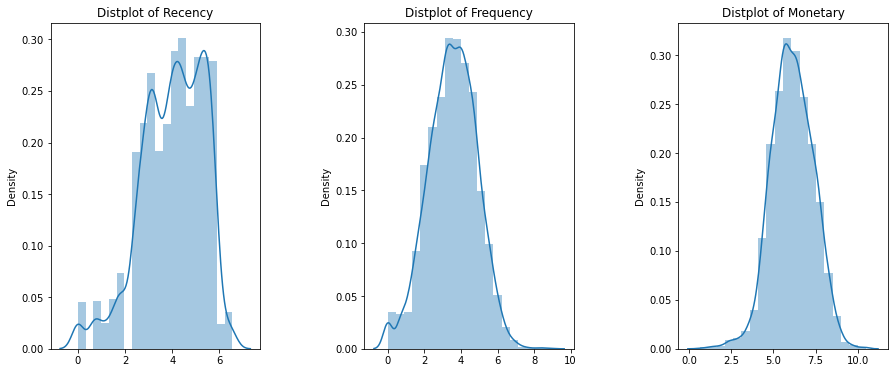

In [39]:
# distribution after nomalization
plt.figure(1, figsize = (15, 6))
n = 0
for x in ['Recency', 'Frequency', 'Monetary']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.distplot([Log_Tfd_Data[x]], bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show

In [40]:
# Check varian
Log_Tfd_Data.var()

Recency      1.745183
Frequency    1.748074
Monetary     1.561339
dtype: float64

In [41]:
# array of Recency & Frequency
K_arr = H_arr = Log_Tfd_Data.iloc[:, [0, 1]].values

## 4. K-Mean Cluster

In [42]:
# Finding optimal number
sum_of_sq_dist = {}
for k in range(1, 11):
    km = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    km = km.fit(Log_Tfd_Data)
    sum_of_sq_dist[k] = km.inertia_

sum_of_sq_dist

{1: 19116.479716725877,
 2: 9995.935683637046,
 3: 7655.320797717047,
 4: 6225.365205700745,
 5: 5243.423108701958,
 6: 4594.428184787113,
 7: 4074.1953865289106,
 8: 3686.4729269990526,
 9: 3394.7064582534776,
 10: 3140.8118412130543}

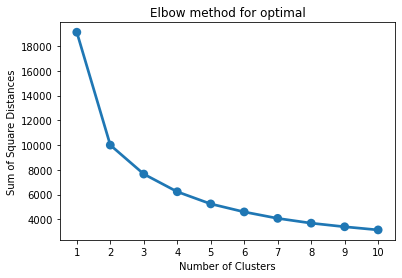

In [43]:
# Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow method for optimal')
plt.show()

According to the graph, optimal number is 3. However, we can try 4 or 5 based on business requirement.

In [44]:
# Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
KMean_clust.fit(Log_Tfd_Data)
y_k = KMean_clust.fit_predict(K_arr)

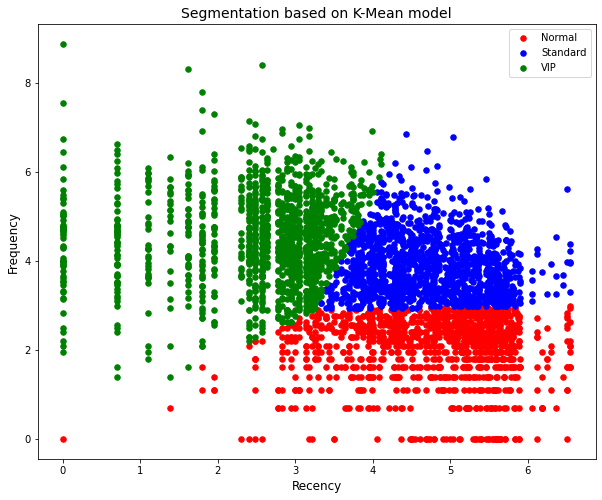

In [45]:
plt.figure(figsize = (10, 8))
plt.scatter(K_arr[y_k == 0, 0], K_arr[y_k == 0, 1], s = 30, c = 'red', label = 'Normal') #alpha = 0.5
plt.scatter(K_arr[y_k == 1, 0], K_arr[y_k == 1, 1], s = 30, c = 'blue', label = 'Standard')
plt.scatter(K_arr[y_k == 2, 0], K_arr[y_k == 2, 1], s = 30, c = 'green', label = 'VIP')

plt.title('Segmentation based on K-Mean model', fontsize = 14)
plt.xlabel('Recency', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend()
plt.show()

Find number of customer & thier payment in each cluster

In [46]:
# assign clustor to each customer
df_cluster = RFM[['Recency', 'Frequency', 'Monetary']]
df_cluster['Clusters'] = KMean_clust.labels_
df_cluster.head()

,Recency,Frequency,Monetary,Clusters
CustomerID,,,,
12747.0,24,78,2640.41,2
12748.0,5,4041,20345.55,2
12749.0,24,143,2662.73,2
12820.0,46,58,923.62,1
12821.0,97,5,75.72,0


In [47]:
# Split customer base on thier cluster

df_VIP = df_cluster[df_cluster['Clusters'] == 2]
df_VIP['Clusters'] = 'VIP'
df_VIP = df_VIP[['Monetary', 'Clusters']]

df_Standard = df_cluster[df_cluster['Clusters'] == 1]
df_Standard['Clusters'] = 'Standard'
df_Standard = df_Standard[['Monetary', 'Clusters']]

df_Normal = df_cluster[df_cluster['Clusters'] == 0]
df_Normal['Clusters'] = 'Normal'
df_Normal = df_Normal[['Monetary', 'Clusters']]

In [48]:
display_side_by_side(df_VIP.head(), df_Standard.head(), df_Normal.head())

,Monetary,Clusters
CustomerID,,
12747.0,2640.41,VIP
12748.0,20345.55,VIP
12749.0,2662.73,VIP
12836.0,1620.12,VIP
12839.0,5115.12,VIP
,Monetary,Clusters
CustomerID,,
12820.0,923.62,Standard
12822.0,743.28,Standard


In [49]:
display_side_by_side(df_VIP.describe(), df_Standard.describe(), df_Normal.describe())

,Monetary
count,1270.000000
mean,1891.940094
std,2645.942909
min,46.920000
25%,581.420000
50%,1167.105000
75%,2275.027500
max,36019.840000
,Monetary
count,1368.000000


In [50]:
# calculate payment for each cluster
temStr = {'NumCust': {'VIP': df_VIP['Monetary'].count(),
                      'Standard': df_Standard['Monetary'].count(),
                      'Normal': df_Normal['Monetary'].count()},
          
          'Payment': {'VIP': round(df_VIP['Monetary'].sum()),
                      'Standard': round(df_Standard['Monetary'].sum()),
                      'Normal': round(df_Normal['Monetary'].sum())}
          }

In [51]:
# dictionary to df
Kmean_compare = pd.DataFrame(temStr)
Kmean_compare

,NumCust,Payment
VIP,1270,2402764
Standard,1368,1064636
Normal,1145,202050


In [52]:
Kmean_num_dic = Kmean_compare['NumCust'].to_dict()
Kmean_pym_dic = Kmean_compare['Payment'].to_dict()

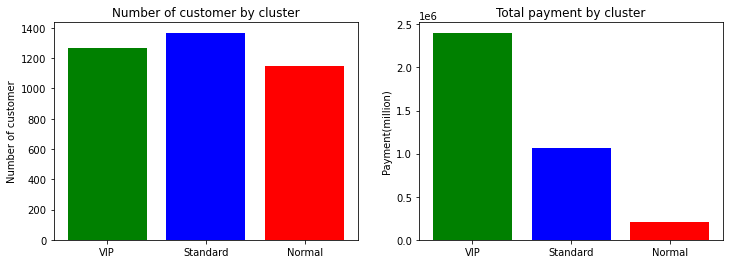

In [53]:
fig = plt.figure(figsize = (12, 4))
ax1 = plt.subplot2grid((1,2), (0,0)) 
ax2 = plt.subplot2grid((1,2), (0,1)) 

# Number of customer in each cluster
ax1.bar(Kmean_num_dic.keys(), Kmean_num_dic.values(), color = ['green', 'blue', 'red'])
ax1.set_title("Number of customer by cluster")
ax1.set_ylabel('Number of customer')

# Total payment of each cluster
ax2.bar(Kmean_pym_dic.keys(), Kmean_pym_dic.values(), color = ['green', 'blue', 'red'])
ax2.set_title("Total payment by cluster")
x = ax2.set_ylabel('Payment(million)')

## 5. Hierarchical Cluster

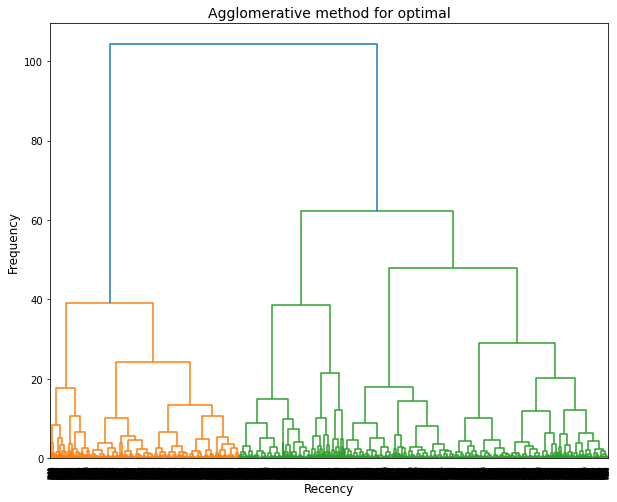

In [54]:
# plot Dendrogram to see otimal number
plt.figure(figsize = (10, 8))
dendrogram = sch.dendrogram(sch.linkage(H_arr, method = 'ward'))
plt.title('Agglomerative method for optimal', fontsize = 14)
plt.xlabel('Recency', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

According to the graph, we can use optimal number as 2 clusters. We can also choose 3 or 4 clusters. But in our case we will choose 3 clusters because we need to compare the result with K-Mean model. 

In [55]:
# Perform hierarchical clustering model (Train model and predict the cluster for each data point)
hCluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hCluster.fit_predict(H_arr) # array y_hc contain on 3 elements: 0, 1, 2

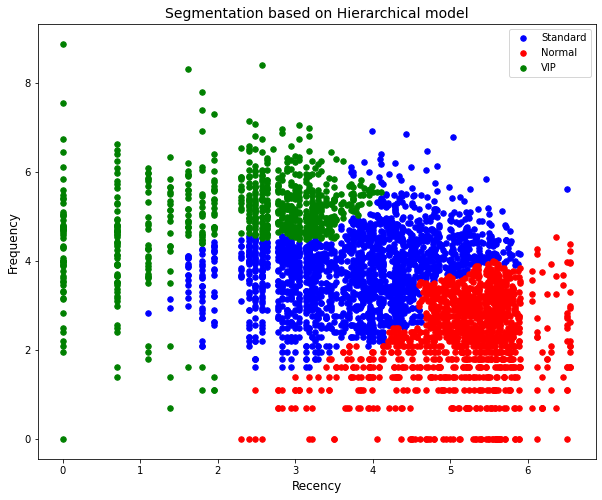

In [56]:
plt.figure(figsize = (10, 8))
plt.scatter(H_arr[y_hc == 0, 0], H_arr[y_hc == 0, 1], s = 30, c = 'blue', label = 'Standard')
plt.scatter(H_arr[y_hc == 1, 0], H_arr[y_hc == 1, 1], s = 30, c = 'red', label = 'Normal')
plt.scatter(H_arr[y_hc == 2, 0], H_arr[y_hc == 2, 1], s = 30, c = 'green', label = 'VIP')
plt.title('Segmentation based on Hierarchical model', fontsize = 14)
plt.xlabel('Recency', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend()
plt.show()

Find number of customer & thier payment in each cluster

In [57]:
# assign clustor to each customer
df_cluster = RFM[['Recency', 'Frequency', 'Monetary']]
df_cluster['Clusters'] = hCluster.labels_
df_cluster.head()

,Recency,Frequency,Monetary,Clusters
CustomerID,,,,
12747.0,24,78,2640.41,0
12748.0,5,4041,20345.55,2
12749.0,24,143,2662.73,2
12820.0,46,58,923.62,0
12821.0,97,5,75.72,1


In [58]:
# cluster number 2 is VIP group
df_VIP = df_cluster[df_cluster['Clusters'] == 2]
df_VIP['Clusters'] = 'VIP'
df_VIP = df_VIP[['Monetary', 'Clusters']]

# cluster number 1 is standard group
df_Standard = df_cluster[df_cluster['Clusters'] == 1]
df_Standard['Clusters'] = 'Standard'
df_Standard = df_Standard[['Monetary', 'Clusters']]

# cluster number 0 is Normal group
df_Normal = df_cluster[df_cluster['Clusters'] == 0]
df_Normal['Clusters'] = 'Normal'
df_Normal = df_Normal[['Monetary', 'Clusters']]

In [59]:
display_side_by_side(df_VIP.head(), df_Standard.head(), df_Normal.head())

,Monetary,Clusters
CustomerID,,
12748.0,20345.55,VIP
12749.0,2662.73,VIP
12836.0,1620.12,VIP
12839.0,5115.12,VIP
12841.0,3308.77,VIP
,Monetary,Clusters
CustomerID,,
12821.0,75.72,Standard
12829.0,28.50,Standard


In [60]:
display_side_by_side(df_VIP.describe(), df_Standard.describe(), df_Normal.describe())

,Monetary
count,709.000000
mean,2671.764725
std,3154.398962
min,19.800000
25%,1045.360000
50%,1955.390000
75%,3278.100000
max,36019.840000
,Monetary
count,1284.000000


In [61]:
# calculate payment for each cluster
temStr = {'NumCust': {'VIP': df_VIP['Monetary'].count(),
                        'Standard': df_Standard['Monetary'].count(),
                        'Normal': df_Normal['Monetary'].count()},
          'Payment': {'VIP': round(df_VIP['Monetary'].sum()),
                      'Standard': round(df_Standard['Monetary'].sum()),
                      'Normal': round(df_Normal['Monetary'].sum())}
          }

In [62]:
# dictionary to df
HAC_compare = pd.DataFrame(temStr)
HAC_compare

,NumCust,Payment
VIP,709,1894281
Standard,1284,286220
Normal,1790,1488949


In [63]:
h_num_dic = HAC_compare['NumCust'].to_dict()
h_pym_dic = HAC_compare['Payment'].to_dict()

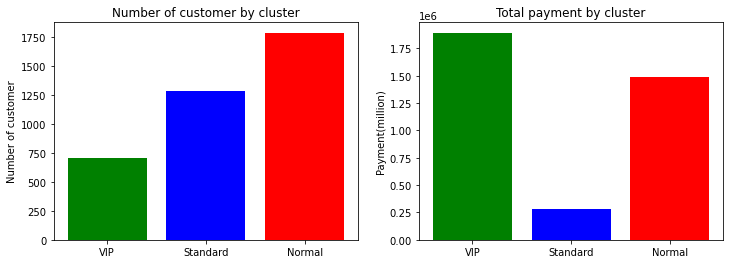

In [64]:
fig = plt.figure(figsize = (12, 4))
ax1 = plt.subplot2grid((1,2), (0,0)) 
ax2 = plt.subplot2grid((1,2), (0,1)) 

# Number of customer in each cluster
ax1.bar(h_num_dic.keys(), h_num_dic.values(), color = ['green', 'blue', 'red'])
ax1.set_title("Number of customer by cluster")
ax1.set_ylabel('Number of customer')

# Total payment of each cluster
ax2.bar(h_pym_dic.keys(), h_pym_dic.values(), color = ['green', 'blue', 'red'])
ax2.set_title("Total payment by cluster")
x = ax2.set_ylabel('Payment(million)')

### 6. Result
Based on what we tested in K-Mean model & Hierarchical model, the company's customer is segmented into 3 groups. Moreover, even though both models produce the same of cluster, but the way they classify segmentation is a bit difference. As we can see in visualization, K-Mean model can classify segmentation of customer clearer than Hierarchical model. In visualization graph of HAC, we can see some of customers in Standard group are spread into VIP group. It’s look like customer in these two groups are not isolated. In contrast, the three groups of customer in Kmean's visualization are very isolated. They are classified in a specific pattern. 

In conclusion base on Kmean model, the customer has segmented as 3 groups:
- VIP: they are the best customer, loyalty, big spend, and mostly engage with company platform
- Standard: they are the customer that is stay in medium level. This group is not often engage if compare to VIP group, but their spending is not quite different from VIP's group. We can say that they are more likely active based on season or event.
- Normal: Customer in this group haven’t purchased for quite long, hey may churn out soon.

### 7. Recommendation:
-	VIP group: This is the group of customer that company can cross-sell. Company can also encourage them to stay in the group of VIP member by giving them some special promotion such as free same-day shipping, priority access to newly launch product etc. 
- Standard group: The company should promote more product, make some more discounts, and introduce them the benefit of VIP's member. So that they can spend more.
-	Normal group: This group of customer may churn out soon. So, company should offer some reward or coupon to push them to purchase the products.